# Constructing a BPF function


In [147]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [148]:
parameters = torch.tensor(np.random.rand(2), requires_grad=True)
parameters_ideal = torch.tensor([100e-12,100e-15],dtype=torch.double)
w = torch.linspace(0,1,101)

def targetImpedance(_w):
    return getImpedance(parameters_ideal,_w)

def getImpedance(parameters,_w):
    L1 = parameters[0]; C1 = parameters[1]; 
    G1 = 1e-3 # NOTE: Need G1!=0 so that the DC impdance is finite!
    M = torch.tensor([
            [1-(_w**2)*L1*C1, 1j*_w*L1],
            [G1 + 1j*_w*C1, 1]
        ])
    _rowSel_A = torch.tensor([[1,0]],dtype=torch.complex128)
    _colSel_A = torch.tensor([[1],[0]],dtype=torch.complex128)
    A = _rowSel_A@M@_colSel_A
    
    _rowSel_C = torch.tensor([[0,1]],dtype=torch.complex128)
    _colSel_C = torch.tensor([[1],[0]],dtype=torch.complex128)
    C = _rowSel_C@M@_colSel_C
    
    Z = A/C
    return Z
def computeError(parameters):
    # return torch.abs(getImpedance(parameters,100) - targetImpedance(100))**2
    # return torch.abs(getImpedance(parameters,w[0]) - targetImpedance(w[0]))**2
    
    return torch.sum(torch.tensor([torch.abs(getImpedance(parameters,_w) - targetImpedance(_w))**2 for _w in w]))

In [ ]:
computeError(parameters_ideal)
# computeError(parameters)

tensor(0., dtype=torch.float64)

In [155]:
def computeError(parameters):
    return torch.sum(torch.abs(parameters)**2)

Iteration 0 : (L1,C1) = tensor([ 0.0374, -0.0323], dtype=torch.float64, requires_grad=True); f = 0.007955646177846758
Iteration 2 : (L1,C1) = tensor([-0.0403,  0.0086], dtype=torch.float64, requires_grad=True); f = 0.0003119086364961803
Iteration 4 : (L1,C1) = tensor([-0.0507,  0.0190], dtype=torch.float64, requires_grad=True); f = 0.0033347733151798216
Iteration 6 : (L1,C1) = tensor([-0.0203, -0.0072], dtype=torch.float64, requires_grad=True); f = 0.0014994673916222598
Iteration 8 : (L1,C1) = tensor([ 0.0162, -0.0161], dtype=torch.float64, requires_grad=True); f = 0.00025522169968620896


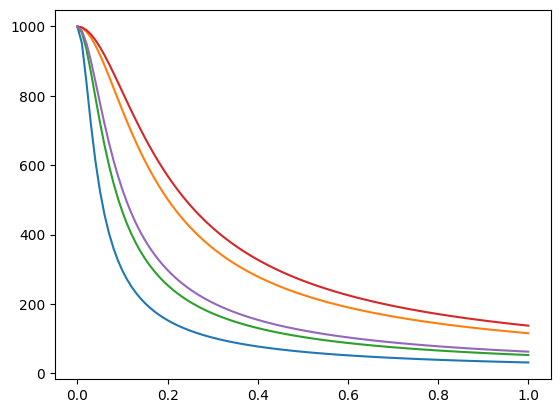

In [157]:
fig, axes = plt.subplots(); legend = []
optimizer = torch.optim.Adam([parameters], lr=0.05) # Adaptive algorithm, better
for i in range(10):
    optimizer.zero_grad()

    # Our desired loss function
    # f = torch.tensor([computeError(parameters,_w) for _w in w])
    f = computeError(parameters)
    # f.requires_grad = True # from https://stackoverflow.com/questions/61808965/pytorch-runtimeerror-element-0-of-tensors-does-not-require-grad-and-does-not-ha
    f.backward()
    optimizer.step()

    if(i%2==0):
        print(f'Iteration {i} : (L1,C1) = {parameters}; f = {f.item()}')
        axes.plot(w,abs(torch.tensor([getImpedance(parameters,_w) for _w in w]).detach().numpy()))
        legend.append(i)
# # legend.append('Target')
# axes.plot(w,abs(polynomial_target))
# axes.legend(legend)
# axes.grid('on')